In [401]:
#Data saved in csv/excel
import glob, os
import pandas as pd

data_dir="C:/Users/tsb7592/Box/Avera NIHTB Data"
os.chdir(data_dir)

In [402]:
import sys 

stdoutOrigin=sys.stdout 
sys.stdout = open("stat_output.txt", "w")

# Compute the Total response time in minutes

In [403]:
# get all files from all RC In-person subdirectories

all_files = glob.glob('C:/Users/tsb7592/Box/Avera NIHTB Data/Rapid City/*/In Person/*CB_Data.csv')

doc =[]
for file in all_files:
    data = pd.read_csv(file)
    print(file)
    doc.append(data)

# get all files from all SF
all_files = glob.glob('C:/Users/tsb7592/Box/Avera NIHTB Data/Sioux Falls/*/In Person/*CB_Data.csv')
for file in all_files:
    data = pd.read_csv(file)
    doc.append(data)

all_files = glob.glob('C:/Users/tsb7592/Box/Avera NIHTB Data/Sioux Falls/*/In Person/*PVT_Data.csv')
sep= []
for file in all_files:
    data = pd.read_csv(file)
    if data.shape[1]!= 11:
        doc.append(data)

    else:
        sep.append(data)
df = pd.concat(doc)

In [404]:
sdf = pd.concat(sep)

In [405]:
sdf.shape

(403, 11)

In [406]:
#Set two decimal points for display
pd.options.display.float_format = "{:.2f}".format

In [407]:
df.columns

Index(['PIN', 'DeviceID', 'Assessment Name', 'InstOrdr', 'InstSctn', 'ItmOrdr',
       'Inst', 'Locale', 'ItemID', 'Response', 'Score', 'Theta', 'TScore',
       'SE', 'DataType', 'Position', 'ResponseTime', 'DateCreated',
       'InstStarted', 'InstEnded', 'App Version', 'iPad Version',
       'Firmware Version'],
      dtype='object')

In [408]:
#Reshape the data for EPSF_00944 and EPSF_00943 from long to wide
sdf=sdf.pivot_table(index=['PIN', 'DeviceID', 'AssessmentName', 'ResponseID', 'ItemID',
       'InstrumentTitle', 'TestName', 'InstrumentID'], columns='Key', values='Value', aggfunc='first').reset_index()

In [409]:
sdf.columns=['PIN', 'DeviceID', 'Assessment Name', 'ResponseID', 'ItemID',
       'Inst', 'TestName', 'InstrumentID', 'App Version', 'DataType',
       'DateCreated', 'Firmware Version', 'InstEnded',
      'InstOrdr', 'InstSctn', 'InstStarted',
       'ItmOrdr', 'Locale', 'Position', 'Response', 'ResponseTime', 'SE',
       'Score', 'Theta', 'iPad Version']

In [410]:
sdf =sdf.drop(columns=['ResponseID','TestName','InstrumentID'])

In [411]:
sdf['Site'] = 'Sioux Falls'

In [412]:
#combine all the data for time calculation
df = df.append(sdf)

In [413]:
df.shape

(2744, 24)

In [414]:
df['PIN'].unique()

array(['210330_EPRC_00032_A_8Y', '210423_EPRC_00160_A_8Y',
       '210407_EPRC_00162_A_8Y', '210331_EPRC_00173_A_8Y',
       '210427_EPRC_00179_A_8Y', '210420_EPRC_00181_A_8Y',
       '210419_EPRC_00380_A_8Y', '210412_EPRC_00550_A_8Y',
       '210413_EPSF_00832_A_8Y', '210413_EPSF_00836_A_8Y',
       '210416_EPSF_00944_B_8Y', '210416_EPSF_00944_A',
       '210412_EPSF_01247_A_8Y', '210414_EPSF_01247_A_8Y',
       '210412_EPSF_01666_A_8Y', '210409_EPSF_00943_A_9.5Y_M'],
      dtype=object)

In [415]:
df['PIN'] = df['PIN'].str[7:19]

In [416]:
#Convert to datetime
df['InstStarted']= pd.to_datetime(df['InstStarted'])
df['InstEnded']= pd.to_datetime(df['InstEnded'])

In [417]:
#groupby PIN, Inst to calculate the time spent in each inst by each participant
mni =df.groupby(['PIN','Inst'])['InstStarted','InstEnded'].first().reset_index()

<ipython-input-417-343c5d240ab3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mni =df.groupby(['PIN','Inst'])['InstStarted','InstEnded'].first().reset_index()


In [418]:
mni['Time']=mni['InstEnded']-mni['InstStarted']

In [419]:
mni=mni.drop(columns=['InstStarted'])

In [420]:
mni.InstEnded= mni.InstEnded.map(lambda x: x.strftime('%Y-%m-%d'))

In [421]:
mni.rename(columns={'InstEnded':'Date'}, inplace=True)

In [422]:
mni.head()

,PIN,Inst,Date,Time
0,EPRC_00032_A,NIH Toolbox Dimensional Change Card Sort Test ...,2021-03-30,0 days 00:05:18
1,EPRC_00032_A,NIH Toolbox Flanker Inhibitory Control and Att...,2021-03-30,0 days 00:03:58
2,EPRC_00032_A,NIH Toolbox List Sorting Working Memory Test A...,2021-03-30,0 days 00:10:36
3,EPRC_00032_A,NIH Toolbox Oral Reading Recognition Test Age ...,2021-03-30,0 days 00:01:26
4,EPRC_00032_A,NIH Toolbox Pattern Comparison Processing Spee...,2021-03-30,0 days 00:01:34


In [423]:
#drop 'NIH Toolbox List Sorting Working Memory Test Age 7+ v2.1' to calculate the time
mni_c=mni[mni['Inst']!='NIH Toolbox List Sorting Working Memory Test Age 7+ v2.1']

In [424]:
mni_c.shape

(114, 4)

In [425]:
#Using the corrected matched ones to calculate the total time spent by each participant
IP =mni_c.groupby(['PIN'])['Time'].sum().reset_index()

In [426]:
#Convert to minute
IP['Time']=round(IP['Time'].dt.total_seconds()/60,2)
mni['Time']=round(mni['Time'].dt.total_seconds()/60,2)

In [427]:
mni['Mode'] = 'In Person'

In [428]:
#this one has the time breakdown for each participant spent on each inst 
mni

,PIN,Inst,Date,Time,Mode
0,EPRC_00032_A,NIH Toolbox Dimensional Change Card Sort Test ...,2021-03-30,5.30,In Person
1,EPRC_00032_A,NIH Toolbox Flanker Inhibitory Control and Att...,2021-03-30,3.97,In Person
2,EPRC_00032_A,NIH Toolbox List Sorting Working Memory Test A...,2021-03-30,10.60,In Person
3,EPRC_00032_A,NIH Toolbox Oral Reading Recognition Test Age ...,2021-03-30,1.43,In Person
4,EPRC_00032_A,NIH Toolbox Pattern Comparison Processing Spee...,2021-03-30,1.57,In Person
...,...,...,...,...,...
123,EPSF_01666_A,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-12,1.82,In Person
124,EPSF_01666_A,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-12,1.67,In Person
125,EPSF_01666_A,NIH Toolbox Picture Sequence Memory Test Age 8...,2021-04-12,6.47,In Person
126,EPSF_01666_A,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,2021-04-12,1.40,In Person


In [429]:
#Average total time for in person
IP['Time'].mean()

23.869333333333334

In [430]:
# get all files from all RC Remote subdirectories

all_files = glob.glob('C:/Users/tsb7592/Box/Avera NIHTB Data/Rapid City/*/Remote/*CB_Data_R.csv')


doc =[]
for file in all_files:
    data = pd.read_csv(file)
    doc.append(data)
  #print(file)

# get all files from all SF Remote subdirectories
all_files = glob.glob('C:/Users/tsb7592/Box/Avera NIHTB Data/Sioux Falls/*/Remote/*CB_Data_R.csv')

for file in all_files:
    data = pd.read_csv(file)
    doc.append(data) 
    print(file)

df = pd.concat(doc)

In [431]:
df.head()

,PIN,DeviceID,Assessment Name,InstOrdr,InstSctn,ItmOrdr,Inst,Locale,ItemID,Response,...,Age,Education,MothersEducation,FathersEducation,GuardiansEducation,StartingLevelOverride,Gender,Handedness,Race,Ethnicity
0,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.00,1.00,1.00,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INTRO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.00,1.00,2.00,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.00,1.00,3.00,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.00,1.00,4.00,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_PRACT2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,210406_EPRC_00032_A_8Y,4C0D4D8F-B79D-47C3-AF1A-4D100D11BF28,Assessment 1,1.00,1.00,5.00,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,en-US,VOCAB_INSTR2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [432]:
df['PIN']=df['PIN'].replace(' ', '', regex=True)

In [433]:
df['PIN'] = df['PIN'].str[7:19]

In [434]:
df['PIN'].unique()

array(['EPRC_00032_A', 'EPRC_00160_A', 'EPRC_00173_A', 'EPRC_00179_A',
       'EPRC_00181_A', 'EPRC_00183_A', 'EPRC_00191_A', 'EPRC_00380_A',
       'EPSF_00832_A', 'EPSF_00836_A', 'EPSF_00847_A', 'EPSF_00944_A',
       'EPSF_00944_B', 'EPSF_01666_A'], dtype=object)

In [435]:
df['InstStarted']= pd.to_datetime(df['InstStarted'])

In [436]:
df['InstEnded']= pd.to_datetime(df['InstEnded'])

In [437]:
mnr =df.groupby(['PIN','Inst'])['InstStarted','InstEnded'].first().reset_index()

<ipython-input-437-36cef9752c8c>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mnr =df.groupby(['PIN','Inst'])['InstStarted','InstEnded'].first().reset_index()


In [438]:
mnr['Time']=mnr['InstEnded']-mnr['InstStarted']

In [439]:
mnr=mnr.drop(columns=['InstStarted'])

In [440]:
mnr.InstEnded= mnr.InstEnded.map(lambda x: x.strftime('%Y-%m-%d'))

In [441]:
RM =mnr.groupby(['PIN'])['Time'].sum().reset_index()

In [442]:
RM['Time']=round(RM['Time'].dt.total_seconds()/60,2)

In [443]:
mnr.rename(columns={'InstEnded':'Date'}, inplace=True)

In [444]:
mnr.PIN.unique()

array(['EPRC_00032_A', 'EPRC_00160_A', 'EPRC_00179_A', 'EPRC_00181_A',
       'EPRC_00183_A', 'EPRC_00191_A', 'EPRC_00380_A', 'EPSF_00832_A',
       'EPSF_00836_A', 'EPSF_00847_A', 'EPSF_00944_A', 'EPSF_00944_B',
       'EPSF_01666_A'], dtype=object)

In [445]:
RM

,PIN,Time
0,EPRC_00032_A,27.20
1,EPRC_00160_A,31.40
2,EPRC_00179_A,27.92
3,EPRC_00181_A,27.35
4,EPRC_00183_A,23.12
5,EPRC_00191_A,28.25
6,EPRC_00380_A,27.92
7,EPSF_00832_A,26.47
8,EPSF_00836_A,27.62
9,EPSF_00847_A,25.82


In [446]:
RM['Time'].mean()

28.39461538461539

In [447]:
mnr['Time']=round(mnr['Time'].dt.total_seconds()/60,2)

In [448]:
mnr['Mode'] ='Remote'

In [449]:
IP

,PIN,Time
0,EPRC_00032_A,25.73
1,EPRC_00160_A,25.63
2,EPRC_00162_A,27.25
3,EPRC_00173_A,29.70
4,EPRC_00179_A,21.40
5,EPRC_00181_A,24.33
6,EPRC_00380_A,24.33
7,EPRC_00550_A,30.62
8,EPSF_00832_A,23.53
9,EPSF_00836_A,26.55


In [450]:
#drop the outliers only have 2 inst for in person
IP=IP[IP['PIN']!='210409_EPSF_00943_A']

In [451]:
times = pd.merge(IP, RM, how= 'inner', on='PIN')

In [452]:
times.columns =['PIN','Total_time', 'Total_time_R']

In [453]:
times

,PIN,Total_time,Total_time_R
0,EPRC_00032_A,25.73,27.20
1,EPRC_00160_A,25.63,31.40
2,EPRC_00179_A,21.40,27.92
3,EPRC_00181_A,24.33,27.35
4,EPRC_00380_A,24.33,27.92
5,EPSF_00832_A,23.53,26.47
6,EPSF_00836_A,26.55,27.62
7,EPSF_00944_A,23.88,34.08
8,EPSF_00944_B,23.62,34.43
9,EPSF_01666_A,25.17,27.55


In [454]:
IP.PIN.unique()

array(['EPRC_00032_A', 'EPRC_00160_A', 'EPRC_00162_A', 'EPRC_00173_A',
       'EPRC_00179_A', 'EPRC_00181_A', 'EPRC_00380_A', 'EPRC_00550_A',
       'EPSF_00832_A', 'EPSF_00836_A', 'EPSF_00943_A', 'EPSF_00944_A',
       'EPSF_00944_B', 'EPSF_01247_A', 'EPSF_01666_A'], dtype=object)

In [455]:
RM.PIN.unique()

array(['EPRC_00032_A', 'EPRC_00160_A', 'EPRC_00179_A', 'EPRC_00181_A',
       'EPRC_00183_A', 'EPRC_00191_A', 'EPRC_00380_A', 'EPSF_00832_A',
       'EPSF_00836_A', 'EPSF_00847_A', 'EPSF_00944_A', 'EPSF_00944_B',
       'EPSF_01666_A'], dtype=object)

In [456]:
times

,PIN,Total_time,Total_time_R
0,EPRC_00032_A,25.73,27.20
1,EPRC_00160_A,25.63,31.40
2,EPRC_00179_A,21.40,27.92
3,EPRC_00181_A,24.33,27.35
4,EPRC_00380_A,24.33,27.92
5,EPSF_00832_A,23.53,26.47
6,EPSF_00836_A,26.55,27.62
7,EPSF_00944_A,23.88,34.08
8,EPSF_00944_B,23.62,34.43
9,EPSF_01666_A,25.17,27.55


# 1. A matched t-test for those who have both in-person and remote - Total Time
There are only 8 students both have in person and remote

In [457]:
round(times.std(),2)

Total_time     1.46
Total_time_R   2.97
dtype: float64

In [458]:
import numpy as np
import scipy.stats as stats
print('***A matched t-test for those who have both in-person and remote - Total Time***')
print('t-statistic = %6.2f pvalue = %6.2f' % stats.ttest_ind(times.Total_time, times.Total_time_R, equal_var = False))

In [459]:
import numpy as np, statsmodels.stats.api as sms

X1, X2 = times['Total_time'], times['Total_time_R']

cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
print('95 CI=[%6.2f,%6.2f]' %cm.tconfint_diff(usevar='unequal'))

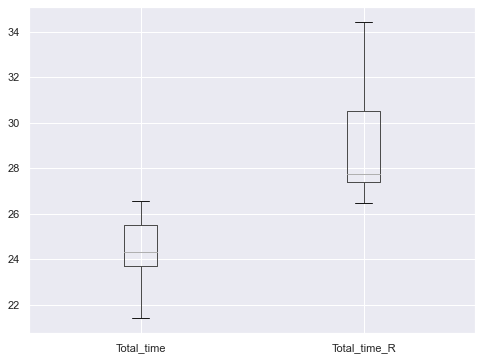

In [460]:
import matplotlib.pyplot as plt

# Box plot of ACS In person vs. Remote
plt.figure(figsize=(8, 6))
times.boxplot(column=['Total_time', 'Total_time_R'])

plt.show()

# 2.	Correlations between remote and in-person- Total Time
There are only 8 students both have in person and remote

In [461]:
import numpy as np
import scipy.stats as stats
print('')
print('Correlation = %6.2f pvalue = %6.2f' % stats.pearsonr(times['Total_time'], times['Total_time_R']))    # Pearson's correlation coefficient and p-value 

In [462]:
time_breakdown = pd.concat([mni,mnr]) 

In [463]:
#time_breakdown.to_csv('C:/Users/tsb7592/Box/Avera NIHTB Data/Subset/time_breakdown.csv', index=False)

In [464]:
time_breakdown.groupby(['PIN','Mode'])['Inst'].count()

PIN           Mode     
EPRC_00032_A  In Person    9
              Remote       8
EPRC_00160_A  In Person    9
              Remote       8
EPRC_00162_A  In Person    9
EPRC_00173_A  In Person    9
EPRC_00179_A  In Person    9
              Remote       8
EPRC_00181_A  In Person    9
              Remote       8
EPRC_00183_A  Remote       6
EPRC_00191_A  Remote       8
EPRC_00380_A  In Person    9
              Remote       8
EPRC_00550_A  In Person    9
EPSF_00832_A  In Person    9
              Remote       8
EPSF_00836_A  In Person    9
              Remote       8
EPSF_00847_A  Remote       8
EPSF_00943_A  In Person    2
EPSF_00944_A  In Person    9
              Remote       8
EPSF_00944_B  In Person    9
              Remote       8
EPSF_01247_A  In Person    9
EPSF_01666_A  In Person    9
              Remote       7
Name: Inst, dtype: int64

# 3.	Does it take longer for remote vs. in-person? - Total Time


In [465]:
print('')
print('Does it take longer for remote vs. in-person? - Total Time')
print('t-statistic = %6.3f pvalue = %6.3f' % stats.wilcoxon(times.Total_time, times.Total_time_R, alternative='two-sided'))
print('')

In [466]:
times.to_csv('C:/Users/tsb7592/Box/Avera NIHTB Data/Subset/times.csv', index=False)

# 4.	A student’s t-test for everyone 


In [467]:
#in person mean time
round(IP.Time.mean(),2)

23.87

In [468]:
#remote mean time
round(RM.Time.mean(),2)

28.39

In [469]:
RM

,PIN,Time
0,EPRC_00032_A,27.20
1,EPRC_00160_A,31.40
2,EPRC_00179_A,27.92
3,EPRC_00181_A,27.35
4,EPRC_00183_A,23.12
5,EPRC_00191_A,28.25
6,EPRC_00380_A,27.92
7,EPSF_00832_A,26.47
8,EPSF_00836_A,27.62
9,EPSF_00847_A,25.82


In [470]:
print('A student’s t-test for everyone - unmatched')
print('t-statistic = %6.2f pvalue = %6.2f' % stats.ttest_ind(IP.Time, RM.Time, equal_var=False))

In [471]:
X1, X2 = IP.Time, RM.Time
#print(len(X1), len(X2))

cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
print('95 CI=[%6.2f,%6.2f]' %cm.tconfint_diff(usevar='unequal'))
print('')

# 5.	Plot on x-axis remote scores for all the Inst, and plot on y-axis all the in-person 

In [472]:
import seaborn as sns
sns.set_theme(style="darkgrid")
#g = sns.jointplot(x="Total_time", y="Total_time_R", data=times,kind="reg", truncate=False,  color="m", height=7)

In [473]:
mni.Inst

0      NIH Toolbox Dimensional Change Card Sort Test ...
1      NIH Toolbox Flanker Inhibitory Control and Att...
2      NIH Toolbox List Sorting Working Memory Test A...
3      NIH Toolbox Oral Reading Recognition Test Age ...
4      NIH Toolbox Pattern Comparison Processing Spee...
                             ...                        
123    NIH Toolbox Pattern Comparison Processing Spee...
124    NIH Toolbox Pattern Comparison Processing Spee...
125    NIH Toolbox Picture Sequence Memory Test Age 8...
126    NIH Toolbox Picture Vocabulary Test Age 3+ Pra...
127      NIH Toolbox Picture Vocabulary Test Age 3+ v2.1
Name: Inst, Length: 128, dtype: object

In [474]:
time_anova=mni.append(mnr)

In [475]:
time_anova["Inst"].replace({'NIH Toolbox Picture Vocabulary Test Age 3+ Practice v2.1':'Pic_Vocabulary',
                            'NIH Toolbox Picture Vocabulary Test Age 3+ v2.1':'Pic_Vocabulary',
       'NIH Toolbox Flanker Inhibitory Control and Attention Test Ages 8-11 v2.1':'Flanker',
       'NIH Toolbox List Sorting Working Memory Test Age 7+ v2.1':'List_Sorting',
       'NIH Toolbox Dimensional Change Card Sort Test Ages 8-11 v2.1':'DCCS',
       'NIH Toolbox Pattern Comparison Processing Speed Test Age 7+ Practice v2.1':'Pattern_Comp',
       'NIH Toolbox Pattern Comparison Processing Speed Test Age 7+ v2.1':'Pattern_Comp',
       'NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1':'Pic_Seq',
       'NIH Toolbox Oral Reading Recognition Test Age 3+ v2.1':'Oral_Reading',
       'NIH Toolbox Picture Sequence Memory Test Age 8+ Form B v2.1':'Pic_Seq',
       'NIH Toolbox Oral Reading Recognition Test Age 3+ Instructions v2.1':'Oral_Reading_Inst'}, inplace=True)

In [476]:
time_anova.Inst.value_counts()

Pic_Vocabulary    56
Pattern_Comp      52
Flanker           27
Pic_Seq           27
DCCS              27
Oral_Reading      26
List_Sorting      14
Name: Inst, dtype: int64

In [477]:
mt=time_anova.pivot_table(index=['PIN', 'Mode'], columns='Inst', values='Time', aggfunc='first').reset_index()
mt=mt.drop(columns=['List_Sorting'])
mt =mt.dropna()

In [478]:
mt

Inst,PIN,Mode,DCCS,Flanker,Oral_Reading,Pattern_Comp,Pic_Seq,Pic_Vocabulary
0,EPRC_00032_A,In Person,5.30,3.97,1.43,1.57,8.92,1.50
1,EPRC_00032_A,Remote,5.60,3.95,1.75,2.03,8.08,2.80
2,EPRC_00160_A,In Person,5.75,3.67,2.07,2.00,7.32,1.73
3,EPRC_00160_A,Remote,7.67,5.58,2.28,2.00,9.78,0.55
4,EPRC_00162_A,In Person,5.15,3.63,2.00,1.47,9.22,1.55
5,EPRC_00173_A,In Person,6.00,4.17,2.97,2.85,8.05,1.98
6,EPRC_00179_A,In Person,5.10,3.33,1.27,1.48,6.00,0.92
7,EPRC_00179_A,Remote,5.50,4.10,1.75,1.72,9.37,2.00
8,EPRC_00181_A,In Person,5.33,3.63,1.43,1.63,8.38,1.05
9,EPRC_00181_A,Remote,5.77,5.23,1.30,1.82,8.87,1.42


In [479]:
# multiple ANOVA

from statsmodels.multivariate.manova import MANOVA

maovt = MANOVA.from_formula('DCCS+ Flanker + Oral_Reading + Pattern_Comp + Pic_Seq + Pic_Vocabulary ~ Mode', data=mt)
print('***multiple ANOVA ---Time***')
print(maovt.mv_test())

# Get demographic data

In [480]:
# get all files from all RC In-person subdirectories

all_files = glob.glob('C:/Users/tsb7592/Box/Avera NIHTB Data/Rapid City/*/In Person/*CB_Reg.csv')

doc =[]
for file in all_files:
    data = pd.read_csv(file)
    doc.append(data)
    
all_files = glob.glob('C:/Users/tsb7592/Box/Avera NIHTB Data/Rapid City/*/Remote/*Reg_R.csv')

for file in all_files:
    data = pd.read_csv(file)
    doc.append(data)

# get all files from all SF
all_files = glob.glob('C:/Users/tsb7592/Box/Avera NIHTB Data/Sioux Falls/*/In Person/*CB_Reg.csv')
for file in all_files:
    data = pd.read_csv(file)
    doc.append(data)

# get all files from all SF
all_files = glob.glob('C:/Users/tsb7592/Box/Avera NIHTB Data/Sioux Falls/*/In Person/*Reg_R.csv')
for file in all_files:
    data = pd.read_csv(file)
    doc.append(data)

ddf = pd.concat(doc)

In [481]:
dcol =['PIN','Gender','Age','Race','Ethnicity']

In [482]:
ddf['PIN'] = ddf['PIN'].str[7:19]

In [483]:
ddf=ddf[dcol]

In [484]:
ddf=ddf.drop_duplicates()

In [485]:
ddf=ddf.dropna()

In [486]:
#Drop this duplicate 
#ddf= ddf[ddf['PIN']!='EPSF_01247_A']

In [487]:
ddf.reset_index()

,index,PIN,Gender,Age,Race,Ethnicity
0,0,EPRC_00032_A,2.00,8.00,1.00,1.00
1,0,EPRC_00160_A,2.00,8.00,1.00,1.00
2,0,EPRC_00162_A,1.00,8.00,1.00,1.00
3,0,EPRC_00173_A,1.00,8.00,8.00,1.00
4,0,EPRC_00179_A,1.00,8.00,1.00,2.00
5,0,EPRC_00181_A,2.00,8.00,1.00,1.00
6,0,EPRC_00380_A,2.00,8.00,1.00,1.00
7,0,EPRC_00550_A,1.00,8.00,1.00,1.00
8,0,EPRC_00183_A,2.00,8.00,1.00,1.00
9,0,EPRC_00191_A,1.00,8.00,1.00,1.00


In [488]:
ddf.to_csv('C:/Users/tsb7592/Box/Avera NIHTB Data/Subset/demographic_data.csv', index=False)

In [489]:
ddf.Gender.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

2.00    56.25%
1.00    43.75%
Name: Gender, dtype: object

# Scores

In [490]:
#  get all files from RC In-person subdirectories

all_files = glob.glob('C:/Users/tsb7592/Box/Avera NIHTB Data//Rapid City/*/In Person/*CB_Scores.csv')

doc =[]
for file in all_files:
    data = pd.read_csv(file)
    doc.append(data)

# get all files from all SF In_person subdirectories
all_files = glob.glob('C:/Users/tsb7592/Box/Avera NIHTB Data/Sioux Falls/*/In Person/*CB_Scores.csv')

for file in all_files:
    data = pd.read_csv(file)
    doc.append(data)

df = pd.concat(doc)

In [491]:
df.shape

(165, 28)

In [492]:
df['PIN'] = df['PIN'].str[7:19]

In [493]:
keep =['PIN', 'Inst', 'RawScore', 'Theta', 'SE',
       'ItmCnt', 'Computed Score',
       'Uncorrected Standard Score', 'Age-Corrected Standard Score',
       'National Percentile (age adjusted)', 'Fully-Corrected T-score',
       'InstrumentBreakoff', 'InstrumentStatus2']

In [494]:
df=df[keep]

In [495]:
times

,PIN,Total_time,Total_time_R
0,EPRC_00032_A,25.73,27.20
1,EPRC_00160_A,25.63,31.40
2,EPRC_00179_A,21.40,27.92
3,EPRC_00181_A,24.33,27.35
4,EPRC_00380_A,24.33,27.92
5,EPSF_00832_A,23.53,26.47
6,EPSF_00836_A,26.55,27.62
7,EPSF_00944_A,23.88,34.08
8,EPSF_00944_B,23.62,34.43
9,EPSF_01666_A,25.17,27.55


In [496]:
#Differentiate the rows contain Composites
comp =df[df['Inst'].str.contains("Composite")]
raw =df[~df['Inst'].str.contains("Composite")]

In [497]:
raw=raw.dropna(axis=1, how='all')
raw.head()

,PIN,Inst,RawScore,Theta,SE,ItmCnt,Computed Score,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,InstrumentBreakoff,InstrumentStatus2
0,EPRC_00032_A,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,NaN,-2.41,0.47,20.00,NaN,71,95,36,36,2.00,3.00
1,EPRC_00032_A,NIH Toolbox Flanker Inhibitory Control and Att...,20.00,NaN,NaN,24.00,7.24,89,94,34,45,2.00,3.00
2,EPRC_00032_A,NIH Toolbox List Sorting Working Memory Test A...,16.00,NaN,NaN,15.00,NaN,97,108,69,48,2.00,3.00
3,EPRC_00032_A,NIH Toolbox Dimensional Change Card Sort Test ...,26.00,NaN,NaN,38.00,6.73,91,96,40,46,2.00,3.00
4,EPRC_00032_A,NIH Toolbox Pattern Comparison Processing Spee...,34.00,NaN,NaN,34.00,39.00,80,86,18,39,2.00,3.00


In [498]:
comp=comp.dropna(axis=1, how='all')
comp.head()

,PIN,Inst,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score
7,EPRC_00032_A,Cognition Fluid Composite v1.1,93,103,59,48
8,EPRC_00032_A,Cognition Crystallized Composite v1.1,71,85,16,32
9,EPRC_00032_A,Cognition Total Composite Score v1.1,78,93,32,38
10,EPRC_00032_A,Cognition Early Childhood Composite v1.1,89,105,62,48
7,EPRC_00160_A,Cognition Fluid Composite v1.1,94,109,73,49


In [499]:
comp.Inst.unique()

array(['Cognition Fluid Composite v1.1',
       'Cognition Crystallized Composite v1.1',
       'Cognition Total Composite Score v1.1',
       'Cognition Early Childhood Composite v1.1'], dtype=object)

In [500]:
df['Mode'] ='In Person'

In [501]:
#  get all files from RC Remote subdirectories

all_files = glob.glob('C:/Users/tsb7592/Box/Avera NIHTB Data/Rapid City/*/Remote/*CB_Scores_R.csv')

doc =[]
for file in all_files:
    data = pd.read_csv(file)
    doc.append(data)


# get all files from all SF In_person subdirectories
all_files = glob.glob('C:/Users/tsb7592/Box/Avera NIHTB Data/Sioux Falls/*/Remote/*CB_Scores_R.csv')

for file in all_files:
    data = pd.read_csv(file)
    doc.append(data)

dfr = pd.concat(doc)

In [502]:
dfr.shape

(102, 28)

In [503]:
dfr['PIN'].unique()

array(['210406_EPRC_00032_A_8Y', '210415_EPRC_00160_A_8Y',
       '210408_EPRC_00173_A_8Y', '210420_EPRC_00179_A_8Y',
       '210415_EPRC_00181_A_8Y', '210415_EPRC_00183_A_8Y',
       '210426_EPRC_00191_A_8Y', '210408_EPSF_00832_A_8Y',
       '210415_EPSF_00836_A_8Y', '210409_EPSF_00847_A_8Y',
       '210409_EPSF_00944_A_8Y', '210409_EPSF_00944_B_8Y',
       '210408_EPSF _01666_A_NT_CB'], dtype=object)

In [504]:
dfr['PIN']=dfr['PIN'].replace(' ', '', regex=True)

In [505]:
dfr['PIN'] = dfr['PIN'].str[7:19]

In [506]:
dfr=dfr[keep]

In [507]:
dfr.head()

,PIN,Inst,RawScore,Theta,SE,ItmCnt,Computed Score,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,InstrumentBreakoff,InstrumentStatus2
0,EPRC_00032_A,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,NaN,-1.73,0.48,24.00,NaN,74.00,95.00,36.00,44.00,2.00,3.00
1,EPRC_00032_A,NIH Toolbox Oral Reading Recognition Test Age ...,NaN,-5.00,0.50,22.00,NaN,78.00,80.00,10.00,34.00,2.00,3.00
2,EPRC_00032_A,NIH Toolbox Pattern Comparison Processing Spee...,34.00,NaN,NaN,37.00,39.00,80.00,86.00,18.00,39.00,2.00,3.00
3,EPRC_00032_A,NIH Toolbox Picture Sequence Memory Test Age 8...,19.00,0.24,0.31,6.00,585.56,115.00,121.00,92.00,62.00,2.00,3.00
4,EPRC_00032_A,NIH Toolbox Flanker Inhibitory Control and Att...,20.00,NaN,NaN,24.00,6.79,85.00,83.00,13.00,38.00,2.00,3.00


In [508]:
#Differentiate the rows contain Composites
comp_r =dfr[dfr['Inst'].str.contains("Composite")]
raw_r =dfr[~dfr['Inst'].str.contains("Composite")]

In [509]:
comp_r=comp_r.dropna(axis=1, how='all')
comp_r.head()

,PIN,Inst,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score
6,EPRC_00032_A,Cognition Crystallized Composite v1.1,74.00,85.00,16.00,38.00
7,EPRC_00032_A,Cognition Early Childhood Composite v1.1,85.00,98.00,44.00,43.00
6,EPRC_00160_A,Cognition Crystallized Composite v1.1,83.00,106.00,66.00,51.00
7,EPRC_00160_A,Cognition Early Childhood Composite v1.1,79.00,92.00,29.00,42.00
6,EPRC_00173_A,Cognition Crystallized Composite v1.1,63.00,72.00,3.00,39.00


In [510]:
comp['Mode'] = 'In Person'
comp_r['Mode'] = 'Remote'
boxp = pd.concat([comp,comp_r]) 

In [511]:
raw_r=raw_r.dropna(axis=1, how='all')
raw_r.head()

,PIN,Inst,RawScore,Theta,SE,ItmCnt,Computed Score,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,InstrumentBreakoff,InstrumentStatus2
0,EPRC_00032_A,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,NaN,-1.73,0.48,24.00,NaN,74.00,95.00,36.00,44.00,2.00,3.00
1,EPRC_00032_A,NIH Toolbox Oral Reading Recognition Test Age ...,NaN,-5.00,0.50,22.00,NaN,78.00,80.00,10.00,34.00,2.00,3.00
2,EPRC_00032_A,NIH Toolbox Pattern Comparison Processing Spee...,34.00,NaN,NaN,37.00,39.00,80.00,86.00,18.00,39.00,2.00,3.00
3,EPRC_00032_A,NIH Toolbox Picture Sequence Memory Test Age 8...,19.00,0.24,0.31,6.00,585.56,115.00,121.00,92.00,62.00,2.00,3.00
4,EPRC_00032_A,NIH Toolbox Flanker Inhibitory Control and Att...,20.00,NaN,NaN,24.00,6.79,85.00,83.00,13.00,38.00,2.00,3.00


In [512]:
comp_r=comp_r.drop(columns='Mode')

In [513]:
comp=comp.drop(columns='Mode')

In [514]:
comp_r.columns =['PIN', 'Inst', 'Uncorrected Standard Score_r',
       'Age-Corrected Standard Score_r', 'National Percentile (age adjusted)_r',
       'Fully-Corrected T-score_r']

In [515]:
scores = pd.merge(comp, comp_r, on=["PIN",'Inst'])

In [516]:
dfr['Mode'] = 'Remote'

# NIH toolbox 

In [517]:
raw['Mode'] = 'In Person'
raw_r['Mode'] = 'Remote'
boxr = pd.concat([raw,raw_r]) 

In [518]:
keep1=['PIN', 'Inst', 'Age-Corrected Standard Score',
       'Fully-Corrected T-score']

In [519]:
boxr=boxr[['PIN', 'Inst', 'Age-Corrected Standard Score',
       'Fully-Corrected T-score','Mode']]
boxr

,PIN,Inst,Age-Corrected Standard Score,Fully-Corrected T-score,Mode
0,EPRC_00032_A,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,95.00,36.00,In Person
1,EPRC_00032_A,NIH Toolbox Flanker Inhibitory Control and Att...,94.00,45.00,In Person
2,EPRC_00032_A,NIH Toolbox List Sorting Working Memory Test A...,108.00,48.00,In Person
3,EPRC_00032_A,NIH Toolbox Dimensional Change Card Sort Test ...,96.00,46.00,In Person
4,EPRC_00032_A,NIH Toolbox Pattern Comparison Processing Spee...,86.00,39.00,In Person
...,...,...,...,...,...
2,EPSF_01666_A,NIH Toolbox Oral Reading Recognition Test Age ...,NaN,NaN,Remote
3,EPSF_01666_A,NIH Toolbox Oral Reading Recognition Test Age ...,NaN,NaN,Remote
4,EPSF_01666_A,NIH Toolbox Pattern Comparison Processing Spee...,104.00,54.00,Remote
5,EPSF_01666_A,NIH Toolbox Flanker Inhibitory Control and Att...,104.00,46.00,Remote


In [520]:
raw.columns

Index(['PIN', 'Inst', 'RawScore', 'Theta', 'SE', 'ItmCnt', 'Computed Score',
       'Uncorrected Standard Score', 'Age-Corrected Standard Score',
       'National Percentile (age adjusted)', 'Fully-Corrected T-score',
       'InstrumentBreakoff', 'InstrumentStatus2', 'Mode'],
      dtype='object')

In [521]:
raw=raw[keep1]
raw_r = raw_r[keep1]

In [522]:
raw_r.columns =['PIN', 'Inst', 'Age-Corrected Standard Score_r',
       'Fully-Corrected T-score_r']

In [523]:
NIH = pd.merge(raw, raw_r, on=["PIN",'Inst'])

In [524]:
boxr.shape

(184, 5)

In [525]:
from statistics import mean, stdev
from math import sqrt

# Cohen’s d
def chens_d(c0, c1):
    cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
    return cohens_d

In [526]:
boxr.Mode.value_counts()

In Person    105
Remote        79
Name: Mode, dtype: int64

In [527]:
boxr["Inst"].replace({'NIH Toolbox Picture Vocabulary Test Age 3+ v2.1':'Pic_Vocabulary',
       'NIH Toolbox Flanker Inhibitory Control and Attention Test Ages 8-11 v2.1':'Flanker',
       'NIH Toolbox List Sorting Working Memory Test Age 7+ v2.1':'List_Sorting',
       'NIH Toolbox Dimensional Change Card Sort Test Ages 8-11 v2.1':'DCCS',
       'NIH Toolbox Pattern Comparison Processing Speed Test Age 7+ v2.1':'Pattern_Comp',
       'NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1':'Pic_Seq',
       'NIH Toolbox Oral Reading Recognition Test Age 3+ v2.1':'Oral_Reading',
       'NIH Toolbox Picture Sequence Memory Test Age 8+ Form B v2.1':'Pic_Seq',
       'NIH Toolbox Oral Reading Recognition Test Age 3+ Instructions v2.1':'Oral_Reading'}, inplace=True)

In [528]:
boxr=boxr[~boxr.Inst.str.contains("List_Sorting")]

[Text(0, 0, 'Pic_Vocabulary'),
 Text(1, 0, 'Flanker'),
 Text(2, 0, 'DCCS'),
 Text(3, 0, 'Pattern_Comp'),
 Text(4, 0, 'Pic_Seq'),
 Text(5, 0, 'Oral_Reading')]

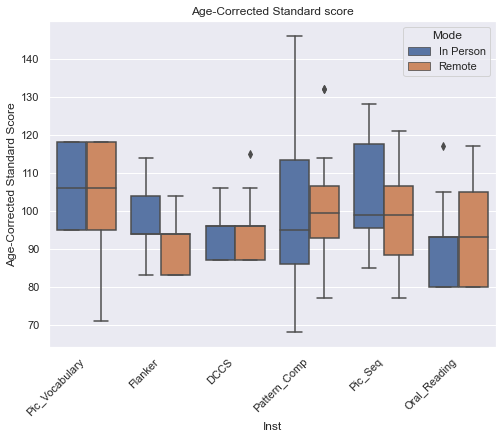

In [529]:
plt.figure(figsize=(8, 6))
chart =sns.boxplot(x = 'Inst', y = 'Age-Corrected Standard Score', hue='Mode',data = boxr)
plt.title('Age-Corrected Standard score')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0, 0, 'Pic_Vocabulary'),
 Text(1, 0, 'Flanker'),
 Text(2, 0, 'DCCS'),
 Text(3, 0, 'Pattern_Comp'),
 Text(4, 0, 'Pic_Seq'),
 Text(5, 0, 'Oral_Reading')]

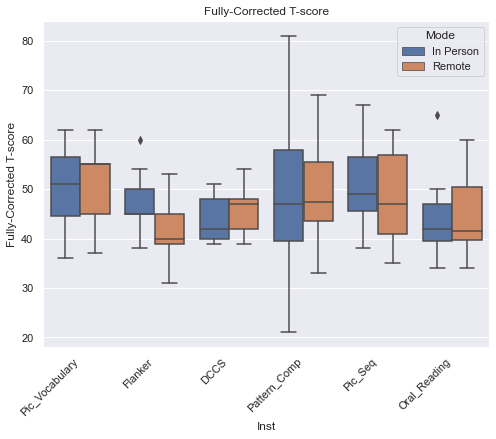

In [530]:
plt.figure(figsize=(8, 6))
chart =sns.boxplot(x = 'Inst', y = 'Fully-Corrected T-score', hue='Mode',data = boxr)
plt.title('Fully-Corrected T-score')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

# multiple ANOVA
https://www.marsja.se/python-manova-made-easy-using-statsmodels/

In [531]:
from statsmodels.multivariate.manova import MANOVA

In [532]:
#Drop this duplicate 
boxr= boxr[boxr['PIN']!='EPSF_01247_A']

In [533]:
boxr.to_csv('C:/Users/tsb7592/Box/Avera NIHTB Data/Subset/ICC_data.csv', index=False)

In [534]:
ma=boxr.pivot_table(index=['PIN', 'Mode'], columns='Inst', values='Age-Corrected Standard Score', aggfunc='first').reset_index()
mf=boxr.pivot_table(index=['PIN', 'Mode'], columns='Inst', values='Fully-Corrected T-score', aggfunc='first').reset_index()

In [535]:
#ma=ma.drop(columns=['List_Sorting'])

In [536]:
ma =ma.dropna()

In [537]:
ma

Inst,PIN,Mode,DCCS,Flanker,Oral_Reading,Pattern_Comp,Pic_Seq,Pic_Vocabulary
0,EPRC_00032_A,In Person,96.00,94.00,80.00,86.00,128.00,95.00
1,EPRC_00032_A,Remote,96.00,83.00,80.00,86.00,121.00,95.00
2,EPRC_00160_A,In Person,96.00,94.00,93.00,104.00,121.00,106.00
3,EPRC_00160_A,Remote,87.00,83.00,93.00,104.00,92.00,118.00
4,EPRC_00162_A,In Person,96.00,104.00,93.00,104.00,85.00,106.00
5,EPRC_00173_A,In Person,87.00,104.00,80.00,123.00,99.00,95.00
7,EPRC_00179_A,In Person,106.00,104.00,93.00,95.00,114.00,118.00
9,EPRC_00181_A,In Person,87.00,94.00,105.00,95.00,92.00,95.00
10,EPRC_00181_A,Remote,96.00,83.00,105.00,104.00,99.00,95.00
12,EPRC_00191_A,Remote,96.00,94.00,80.00,95.00,85.00,106.00


In [538]:
ma.columns

Index(['PIN', 'Mode', 'DCCS', 'Flanker', 'Oral_Reading', 'Pattern_Comp',
       'Pic_Seq', 'Pic_Vocabulary'],
      dtype='object', name='Inst')

In [539]:
maov = MANOVA.from_formula('DCCS+ Flanker +Oral_Reading+Pattern_Comp+Pic_Seq+Pic_Vocabulary~ Mode', data=ma)

In [540]:
print('***multiple ANOVA ---Aged***')
print(maov.mv_test())
print('')

In [541]:
mf =mf.dropna()

In [542]:
maov1 = MANOVA.from_formula('DCCS+ Flanker +Oral_Reading+Pattern_Comp+Pic_Seq+Pic_Vocabulary~ Mode', data=mf)

In [543]:
print('***multiple ANOVA ---Fully***')
print(maov1.mv_test())
print('')

In [544]:
meas =['DCCS','Pic_Vocabulary',
 'Flanker',
 'Pattern_Comp',
 'Pic_Seq',
 'Oral_Reading']

In [545]:
!pip3 install pingouin

In [546]:
from sklearn.metrics import cohen_kappa_score
import pingouin as pg
#cohen_kappa_score(labeler1, labeler2)

In [547]:
matchcol = ['NIH Toolbox Dimensional Change Card Sort Test Ages 8-11 v2.1',
             'NIH Toolbox Picture Vocabulary Test Age 3+ v2.1',
       'NIH Toolbox Flanker Inhibitory Control and Attention Test Ages 8-11 v2.1',
       'NIH Toolbox Pattern Comparison Processing Speed Test Age 7+ v2.1',
       'NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1',
       'NIH Toolbox Oral Reading Recognition Test Age 3+ v2.1']

In [548]:
aicc = pg.intraclass_corr(data=boxr, targets='Inst', raters='Mode',ratings='Age-Corrected Standard Score', nan_policy='omit')
display(aicc.loc[[3,5]])
print('***Average ICC across all measures - Aged***')
print('ICC Average raters absolute', round(aicc.loc[3]['ICC'],2), aicc.loc[3]['CI95%'])
print('ICC Average fixed raters', round(aicc.loc[5]['ICC'],2), aicc.loc[5]['CI95%'])
print('')

,Type,Description,ICC,F,df1,df2,pval,CI95%
3,ICC1k,Average raters absolute,0.78,4.64,5,6,0.04,"[-0.29, 0.97]"
5,ICC3k,Average fixed raters,0.77,4.42,5,5,0.06,"[-0.62, 0.97]"


In [549]:
ficc = pg.intraclass_corr(data=boxr, targets='Inst', raters='Mode',ratings='Fully-Corrected T-score', nan_policy='omit')
display(ficc.loc[[3,5]])
print('***Average ICC across all measures - Fully***')
print('ICC Average raters absolute', round(ficc.loc[3]['ICC'],2), ficc.loc[3]['CI95%'])
print('ICC Average fixed raters', round(ficc.loc[5]['ICC'],2), ficc.loc[5]['CI95%'])
print('')

,Type,Description,ICC,F,df1,df2,pval,CI95%
3,ICC1k,Average raters absolute,0.73,3.67,5,6,0.07,"[-0.63, 0.96]"
5,ICC3k,Average fixed raters,0.68,3.10,5,5,0.12,"[-1.31, 0.95]"


# a.	A matched t-test for those who have both in-person and remote 

In [550]:
def matched_ttest(data, match = None):
    if not match:
        match = list(data.Inst.unique())
    for i in range(len(match)):
        subset=boxr.set_index('Inst').filter(like=meas[i], axis=0)
        subset = subset.dropna()
        icc = pg.intraclass_corr(data=subset, targets='PIN', raters='Mode',ratings='Age-Corrected Standard Score', nan_policy='omit')
        icc2 = pg.intraclass_corr(data=subset, targets='PIN', raters='Mode',ratings='Fully-Corrected T-score', nan_policy='omit')
        minst = match[i]
        print('-',minst,'-')
        subset=data.set_index('Inst').filter(like=minst, axis=0)
        subset = subset.dropna()
        a =np.array(subset['Age-Corrected Standard Score'])
        b =np.array(subset['Age-Corrected Standard Score_r'])
        c =np.array(subset['Fully-Corrected T-score'])
        d =np.array(subset['Fully-Corrected T-score_r'])                
        display(subset.describe().iloc[:3])
        print('Age R:', round(b.mean(),2) , '(',round(stdev(b),2),')')
        print('Age:', round(a.mean(),2) , '(',round(stdev(a),2),')')
        print('Aged cohen %6.2f' % chens_d(a, b))
        print('Aged: ICC Average raters absolute', round(icc.loc[3]['ICC'],2), icc.loc[3]['CI95%'])
        print('Fully R:', round(d.mean(),2) , '(',round(stdev(d),2),')')
        print('Fully:', round(c.mean(),2) , '(',round(stdev(c),2),')')
        print('Fully cohen %6.2f' % chens_d(c, d))
        print('Fully: ICC Average raters absolute', round(icc2.loc[3]['ICC'],2), icc2.loc[3]['CI95%'])
        print('')

        #display(icc.loc[[3,5]])
        #display(icc2.loc[[3,5]])
        print('1. matched t-test:')
        print('Aged: t-statistic = %6.2f, pvalue = %6.3f' %  stats.ttest_ind(a, b, equal_var = False))
        print('Degree of freedom:', len(a)-1)
        print('Fully: t-statistic = %6.2f, pvalue = %6.3f' % stats.ttest_ind(c, d, equal_var = False))
        print('Degree of freedom:', len(c)-1)
        print('')
        print('2. Correlations between in person and remote:')
        print('Aged: correlation = %6.2f, pvalue = %6.3f' % stats.pearsonr(a, b))
        print('Fully: correlation = %6.2f, pvalue = %6.3f' %stats.pearsonr(c,d))
        print('')  
        print('3. Does it take longer for remote vs. in-person? two-sided test')
        print('Aged: t-statistic = %6.2f pvalue = %6.3f' % stats.wilcoxon(a,b))
        print('Fully: t-statistic = %6.2f pvalue = %6.3f' % stats.wilcoxon(c, d))
        print('')
       # g = sns.jointplot(x="Age-Corrected Standard Score", y="Age-Corrected Standard Score_r", data=subset, kind="reg", truncate=False,color="y", height=7)
        #g.fig.suptitle(minst)
        print('')
        #g = sns.jointplot(x="Fully-Corrected T-score", y="Fully-Corrected T-score_r", data=subset, kind="reg", truncate=False,color="r", height=7)
       # g.fig.suptitle(minst)
        print('')
    return

In [551]:
NIH[NIH['Inst']=='NIH Toolbox Picture Sequence Memory Test Age 8+ Form A v2.1'].describe().iloc[:3]

,Age-Corrected Standard Score,Fully-Corrected T-score,Age-Corrected Standard Score_r,Fully-Corrected T-score_r
count,10.00,10.00,8.00,8.00
mean,107.80,53.20,95.50,47.00
std,12.72,8.35,12.90,8.96


In [552]:
NIH.to_csv('C:/Users/tsb7592/Box/Avera NIHTB Data/Subset/NIH.csv', index=False)

In [553]:
print('***NIH: A matched t-test for those who have both in-person and remote***\n')
matched_ttest(NIH, matchcol)

,Age-Corrected Standard Score,Fully-Corrected T-score,Age-Corrected Standard Score_r,Fully-Corrected T-score_r
count,10.00,10.00,10.00,10.00
mean,93.40,44.70,94.30,45.30
std,6.29,4.14,5.91,4.47


C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,Age-Corrected Standard Score,Fully-Corrected T-score,Age-Corrected Standard Score_r,Fully-Corrected T-score_r
count,10.00,10.00,10.00,10.00
mean,104.10,50.20,100.60,49.80
std,10.55,9.05,14.80,8.12


C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,Age-Corrected Standard Score,Fully-Corrected T-score,Age-Corrected Standard Score_r,Fully-Corrected T-score_r
count,10.00,10.00,10.00,10.00
mean,97.90,47.50,89.50,41.00
std,8.62,7.47,7.47,5.77


C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,Age-Corrected Standard Score,Fully-Corrected T-score,Age-Corrected Standard Score_r,Fully-Corrected T-score_r
count,10.00,10.00,10.00,10.00
mean,102.10,50.80,104.30,51.50
std,22.70,14.97,17.90,10.49


C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,Age-Corrected Standard Score,Fully-Corrected T-score,Age-Corrected Standard Score_r,Fully-Corrected T-score_r
count,8.00,8.00,8.00,8.00
mean,108.12,52.62,95.50,47.00
std,13.83,9.36,12.90,8.96


C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,Age-Corrected Standard Score,Fully-Corrected T-score,Age-Corrected Standard Score_r,Fully-Corrected T-score_r
count,9.00,9.00,9.00,9.00
mean,91.22,45.33,91.22,43.89
std,13.07,9.06,11.62,7.13


C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


# 5.	A student’s t-test for everyone 

In [554]:
def remove_nan(li):
    array1 = np.array(li)

    nan_array = np.isnan(array1)
    not_nan_array = ~ nan_array
    array2 = array1[not_nan_array]

    return array2

In [555]:
def unmatched_ttest(ip, rm, match=None):
    if not match:
        match = list(ip.Inst.unique())
    
    for minst in match:
        
        a =np.array(ip.set_index('Inst').filter(like=minst, axis=0)['Age-Corrected Standard Score'])
        b =np.array(rm.set_index('Inst').filter(like=minst, axis=0)['Age-Corrected Standard Score_r'])
        c =np.array(ip.set_index('Inst').filter(like=minst, axis=0)['Fully-Corrected T-score'])
        d =np.array(rm.set_index('Inst').filter(like=minst, axis=0)['Fully-Corrected T-score_r'])
        
        a=remove_nan(a)
        b=remove_nan(b)
        c= remove_nan(c)
        d= remove_nan(d)
        if(len(a)*len(b)*len(c)*len(d))==0:
            continue
        print('-',minst,'-')
            
        print('Age R:', round(b.mean(),2) , '(',round(stdev(b),2),')' , 'N=',len(b))
        print('Age:', round(a.mean(),2) , '(',round(stdev(a),2),')',  'N=',len(a))
        print('Fully R:', round(d.mean(),2) , '(',round(stdev(d),2),')',  'N=',len(d))
        print('Fully:', round(c.mean(),2) , '(',round(stdev(c),2),')',  'N=',len(c))
        print('')
        print('Aged cohen %6.2f' % chens_d(a, b), 'Fully cohen %6.2f' % chens_d(c, d))    
        print('')
        print('Aged: t-statistic = %6.2f, pvalue = %6.3f' % stats.ttest_ind(a,b, equal_var=False))
        print('Fully: t-statistic = %6.2f, pvalue = %6.3f' % stats.ttest_ind(c,d, equal_var=False))
        print('')
    return 

In [556]:
print('***NIH: unmatched t-test for everyone***\n')
unmatched_ttest(raw, raw_r, matchcol)

# Composite Scores

#1.	A matched t-test for those who have both in-person and remote
#2.	Correlations between remote and in-person
#3.	Does it take longer for remote vs. in-person
#4.	Plot on x-axis remote scores for all the Inst, and plot on y-axis all the in-person 

In [557]:
import seaborn as sns
sns.set_theme(style="darkgrid")

In [558]:
scores.to_csv('C:/Users/tsb7592/Box/Avera NIHTB Data/Subset/CompositeScores.csv', index=False)

In [559]:
print('***Composite: A matched t-test for those who have both in-person and remote***\n')
matched_ttest(scores)

,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,Uncorrected Standard Score_r,Age-Corrected Standard Score_r,National Percentile (age adjusted)_r,Fully-Corrected T-score_r
count,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00
mean,77.00,97.56,43.78,48.00,76.56,95.33,41.44,46.67
std,5.68,10.97,24.18,8.92,7.20,13.87,29.16,8.02


C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,Uncorrected Standard Score_r,Age-Corrected Standard Score_r,National Percentile (age adjusted)_r,Fully-Corrected T-score_r
count,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00
mean,83.62,99.88,50.62,46.62,79.50,92.75,32.25,42.25
std,5.80,8.59,21.02,5.13,3.63,5.20,12.53,4.46


C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\tsb7592\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [560]:
boxp.tail()

,PIN,Inst,Uncorrected Standard Score,Age-Corrected Standard Score,National Percentile (age adjusted),Fully-Corrected T-score,Mode
6,EPSF_00944_A,Cognition Crystallized Composite v1.1,76.00,92.00,30.00,47.00,Remote
7,EPSF_00944_A,Cognition Early Childhood Composite v1.1,77.00,89.00,24.00,39.00,Remote
6,EPSF_00944_B,Cognition Crystallized Composite v1.1,71.00,85.00,16.00,42.00,Remote
7,EPSF_00944_B,Cognition Early Childhood Composite v1.1,81.00,94.00,35.00,44.00,Remote
7,EPSF_01666_A,Cognition Early Childhood Composite v1.1,79.00,92.00,29.00,41.00,Remote


In [561]:
boxp["Inst"].replace({"Cognition Fluid Composite v1.1":'CFC','Cognition Crystallized Composite v1.1':'CCC', 'Cognition Total Composite Score v1.1':'CTC','Cognition Early Childhood Composite v1.1':'CECC'}, inplace=True)

Text(0.5, 1.0, 'Age-Corrected Standard score')

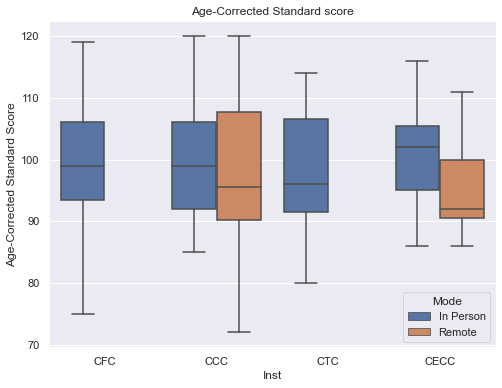

In [562]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'Inst', y = 'Age-Corrected Standard Score', hue='Mode',data = boxp)
plt.title('Age-Corrected Standard score')

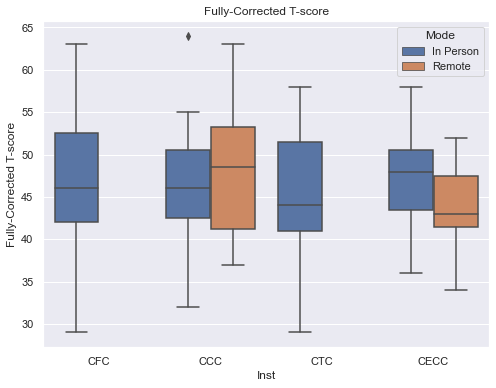

In [563]:
# Box plot of Fully In person vs. Remote
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'Inst', y = 'Fully-Corrected T-score', hue='Mode',data = boxp)
plt.title('Fully-Corrected T-score')
plt.show()

# 5.	A student’s t-test for everyone 

In [564]:
print('***Composite: unmatched t-test for everyone***\n')
unmatched_ttest(comp, comp_r)

In [565]:
sys.stdout.close()
sys.stdout=stdoutOrigin

# Wide to Long

In [566]:
all = pd.concat([df,dfr]) 

In [567]:
time_breakdown[time_breakdown['PIN']=='EPSF_01247_A']

,PIN,Inst,Date,Time,Mode
110,EPSF_01247_A,NIH Toolbox Dimensional Change Card Sort Test ...,2021-04-12,5.28,In Person
111,EPSF_01247_A,NIH Toolbox Flanker Inhibitory Control and Att...,2021-04-12,3.53,In Person
112,EPSF_01247_A,NIH Toolbox List Sorting Working Memory Test A...,2021-04-12,6.73,In Person
113,EPSF_01247_A,NIH Toolbox Oral Reading Recognition Test Age ...,2021-04-12,1.63,In Person
114,EPSF_01247_A,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-12,1.73,In Person
115,EPSF_01247_A,NIH Toolbox Pattern Comparison Processing Spee...,2021-04-12,1.72,In Person
116,EPSF_01247_A,NIH Toolbox Picture Sequence Memory Test Age 8...,2021-04-12,7.22,In Person
117,EPSF_01247_A,NIH Toolbox Picture Vocabulary Test Age 3+ Pra...,2021-04-12,1.38,In Person
118,EPSF_01247_A,NIH Toolbox Picture Vocabulary Test Age 3+ v2.1,2021-04-12,1.80,In Person


In [568]:
rv =pd.merge(time_breakdown, all, how='outer',on=['PIN','Inst','Mode'])

In [569]:
rv.shape

(328, 16)

In [570]:
rv['Site'] = np.where(rv['PIN'].str.contains('SF'), 'Sioux Falls', 'Rapid City')

In [571]:
rv.loc[(rv['PIN']=='EPRC_00173_A') & (rv['Mode']=='In Person'),'Date'] ='2021-03-31'
rv.loc[(rv['PIN']=='EPRC_00173_A') & (rv['Mode']=='Remote'),'Date'] ='2021-04-08'

In [572]:
rv.groupby(['PIN','Mode'])['Date'].last()

PIN           Mode     
EPRC_00032_A  In Person    2021-03-30
              Remote       2021-04-06
EPRC_00160_A  In Person    2021-04-23
              Remote       2021-04-16
EPRC_00162_A  In Person    2021-04-07
EPRC_00173_A  In Person    2021-03-31
              Remote       2021-04-08
EPRC_00179_A  In Person    2021-04-27
              Remote       2021-04-20
EPRC_00181_A  In Person    2021-04-20
              Remote       2021-04-15
EPRC_00183_A  Remote       2021-04-15
EPRC_00191_A  Remote       2021-04-26
EPRC_00380_A  In Person    2021-04-19
              Remote       2021-04-12
EPRC_00550_A  In Person    2021-04-12
EPSF_00832_A  In Person    2021-04-13
              Remote       2021-04-08
EPSF_00836_A  In Person    2021-04-13
              Remote       2021-04-15
EPSF_00847_A  Remote       2021-04-09
EPSF_00943_A  In Person    2021-04-09
EPSF_00944_A  In Person    2021-04-16
              Remote       2021-04-09
EPSF_00944_B  In Person    2021-04-16
              Remote      

In [573]:
with pd.ExcelWriter('C:/Users/tsb7592/Box/Avera NIHTB Data/summary.xlsx') as writer:  
    summary.to_excel(writer,sheet_name='all',index= False)

In [574]:
rv.to_csv('C:/Users/tsb7592/Box/Avera NIHTB Data/wide_format_data.csv', index=False)

In [575]:
long = rv.melt(id_vars=['PIN','Inst','Mode','Date','Time','Site'], 
        var_name="Scores", 
        value_name="Value")

In [576]:
long=long.dropna(thresh=6, axis=0)

In [577]:
long=long.drop_duplicates()

In [578]:
long.shape

(2992, 8)

In [579]:
long.to_csv('C:/Users/tsb7592/Box/Avera NIHTB Data/long_format_data.csv', index=False)